# Neuvisys notebook

Display multiple information from a spiking neural network experiment.

In [1]:
%load_ext autoreload
%autoreload 2

import os
import shutil
import pprint
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pdf2image import convert_from_path
from src.spiking_network.network.neuvisys import SpikingNetwork
from src.spiking_network.analysis.network_display import (
    display_network,
    load_array_param,
    complex_cells_directions,
    complex_cell_disparities,
)
from src.spiking_network.analysis.rl_analysis import (
    value_plot,
    policy_plot,
    validation_plot,
    value_policy_evaluation,
)
from src.spiking_network.analysis.network_statistics import (
    event_vs_network_activity,
    rf_matching,
    direction_norm_length,
    orientation_norm_length,
    direction_selectivity,
    orientation_selectivity,
    update_dataframe,
    disparity_histogram,
    inhibition_weight_against_orientation,
    inhibition_weight_against_disparity,
    lateral_inhibition_weight_sum,
    weight_variation,
)
from src.spiking_network.gabor.gabor_fit import gabor_fit_one_patch
from src.spiking_network.analysis.spike_train import (
    spike_trains,
    raster_plot,
    event_plot,
    time_histogram,
    fast_time_histogram,
    spike_rate_histogram,
    isi_histogram,
    instantaneous_rates,
    correlation_coeficient_matrix,
    activity_comparison,
    kernel_convolution,
)
from src.spiking_network.gabor.gabbor_fitting import (
    create_gabor_basis,
    hists_preferred_orientations,
    plot_preferred_orientations,
)
from src.spiking_network.analysis.parameter_analysis import (
    correlation_matrix,
    scatter_mat,
)

os.chdir("/home/thomas/neuvisys-analysis/src")
home = "/home/thomas/"

SMALL_SIZE = 25
MEDIUM_SIZE = 35
BIGGER_SIZE = 40

plt.rc('figure', figsize=(30, 8))
plt.rc('font', size=MEDIUM_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE,
       labelsize=BIGGER_SIZE)  # fontsize of the axes title, fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)  # legend fontsize

## Load Network

loads various information of the spiking neural network into a SpikingNetwork instance.

In [174]:
network_path = "/home/thomas/Networks/simulation/rl_inhibition/orientation_task/network/"
spinet = SpikingNetwork(network_path, loading=[True, True, True, True])

## Weights analysis

Display of the learned receptive fields of the different neuronal layers

In [ ]:
display_network([spinet])

print("Simple cells weights")
if spinet.conf["nbCameras"] == 2:
    display(convert_from_path(network_path + "figures/0/weight_sharing_combined.pdf")[0])
else:
    display(convert_from_path(network_path + "figures/0/weight_sharing_0.pdf")[0])

print("Complex cells weights (average over all simple cells)")
for i in range(spinet.l_shape[1, 2]):
    display(convert_from_path(network_path + "figures/1/complex_weights_depth_" + str(i) + ".pdf")[0])
    break

In [ ]:
network_path = "/home/thomas/Desktop/Experiment/network_0/"
spinet = SpikingNetwork(network_path)
weight_variation(spinet, network_path)

In [ ]:
inhibition_weight_against_orientation(spinet)
# inhibition_weight_against_disparity(spinet)
lateral_inhibition_weight_sum(spinet)

## Load and create gabor basis

In [ ]:
basis = spinet.generate_weight_mat()
res = gabor_fit_one_patch(basis, rf_size=(10, 10), nb_cameras=2)

In [ ]:
spinet.generate_weight_images()
gabor_params_l = create_gabor_basis(spinet, res, 0, nb_ticks=8, error_thresh=220)

## Direction and Orientation selectivity

In [ ]:
rotations = np.array([0, 23, 45, 68, 90, 113, 135, 158, 180, 203, 225, 248, 270, 293, 315, 338])
dir_vec, ori_vec = complex_cells_directions(spinet, rotations)

angles = np.pi * rotations / 180

dirs = []
dis = []
for i in range(len(spinet.neurons[1])):
    dirs.append(direction_norm_length(spinet.directions[:, i], angles))
    dis.append(direction_selectivity(spinet.directions[:, i]))
oris = []
ois = []
for i in range(len(spinet.neurons[1])):
    oris.append(orientation_norm_length(spinet.orientations[:, i], angles[0:8]))
    ois.append(orientation_selectivity(spinet.orientations[:, i]))

## Disparity selectivity

In [ ]:
plt.imshow(spinet.disparities)
plt.colorbar(orientation='horizontal')

plt.figure()
mean = np.mean(spinet.disparities, axis=1)
plt.plot(mean)

In [ ]:
disparities = np.array([-8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8])

dir_vec, ori_vec = complex_cell_disparities(spinet, spinet.disparities, disparities)

# angles = np.pi * rotations / 180
#
# dirs = []
# dis = []
# for i in range(len(spinet.neurons[1])):
#     dirs.append(direction_norm_length(spinet.directions[:, i], angles))
#     dis.append(direction_selectivity(spinet.directions[:, i]))
# oris = []
# ois = []
# for i in range(len(spinet.neurons[1])):
#     oris.append(orientation_norm_length(spinet.orientations[:, i], angles[0:8]))
#     ois.append(orientation_selectivity(spinet.orientations[:, i]))

In [ ]:
event_vs_network_activity(spinet, "/home/thomas/Videos/natural/shapes/shapes.h5", bins=50, thresh=0)

## Sparsity analysis

In [14]:
network_path = "/home/thomas/Networks/natural/activity_recording/juggling/learned_basis/"
spinet_learned = SpikingNetwork(network_path, loading=[True, True, False, False])
network_path = "/home/thomas/Networks/natural/activity_recording/juggling/random_basis/"
spinet_random = SpikingNetwork(network_path, loading=[True, True, False, False])

In [15]:
from src.events.Events import Events
bins = 50

events = Events("/home/thomas/Videos/natural/other/juggling_light_off.h5")
events.shift_timestamps_to_0()
events.crop(93, 50, 160, 160)
hist_bin = np.arange(0, events.get_timestamps()[-1], int(1e3 * bins))
event_variation, _ = np.histogram(events.get_timestamps(), bins=hist_bin)
event_variation = event_variation / np.max(event_variation)

In [ ]:
activity_variation_learned = fast_time_histogram(spinet_learned.spikes[0], bins)
activity_variation_random = fast_time_histogram(spinet_random.spikes[0], bins)

activity_variation_learned = activity_variation_learned / np.max(activity_variation_learned)
activity_variation_random = activity_variation_random / np.max(activity_variation_random)

plt.figure()
plt.plot(event_variation[:activity_variation_random.shape[0]])
plt.plot(activity_variation_random)
plt.plot(activity_variation_learned)

print(events.get_nb_events())

print(spinet_random.spikes[0][spinet_random.spikes[0] != 0].size)
print(spinet_random.spikes[1][spinet_random.spikes[1] != 1].size)

print(spinet_learned.spikes[0][spinet_learned.spikes[0] != 0].size)
print(spinet_learned.spikes[1][spinet_learned.spikes[1] != 1].size)

diff_random = (event_variation[:activity_variation_random.shape[0]] - activity_variation_random)**2
diff_learned = (event_variation[:activity_variation_learned.shape[0]] - activity_variation_learned)**2

plt.figure()
plt.plot(diff_random)
plt.plot(diff_learned)
print(np.sqrt(np.sum(diff_random)), np.sqrt(np.sum(diff_learned)))

## Spike analysis

Displaying information related to spike timings in the network.

This includes:
- Eventplots
- Time histograms
- Inter-spike histograms
- Raster plots
- Instantaneous rates
- Correlation coefficient matrices
- spike rate histograms

In [ ]:
for layer, layer_spike_train in enumerate(spinet.spikes):
    print("Layer " + str(layer + 1) + ", nb neurons = " + str(len(spinet.neurons[layer])) + ":")

    sts = spike_trains(layer_spike_train)
    path = network_path + "figures/"
    # raster_plot(sts, layer, path)
    # event_plot(sts, layer, path)
    time_histogram(sts, layer, 10, path)
    # spike_rate_histogram(layer_spike_train, layer, path)
    # isi_histogram(sts, layer, path)
    # instantaneous_rates(sts, layer, path, 100, 100)
    # correlation_coeficient_matrix(sts, layer, 50, path)
    break

In [ ]:
sts = spike_trains(spinet.spikes[0])
rates = kernel_convolution(sts, 10, 10)
variation = []
for i in range(rates.shape[0]):
    for j in range(rates.shape[0]):
        variation.append(np.sum(np.abs(rates[j] - rates[i])))
    plt.figure()
    plt.title("Activity difference for two temporal simple cells responses on oriented bars")
    plt.xlabel("Bars orientation from 0° to 360°")
    plt.ylabel("Instantaneous activity")
    plt.plot(variation)
    plt.savefig("/home/thomas/Bureau/figures/" + str(i), bbox_inches="tight")
    plt.show()
    variation = []

#### Compare activity between 2 networks

In [2]:
# spinet1 = SpikingNetwork("/home/thomas/Networks/simulation/inhibition_learning/orientation_task/base_static/", loading=[True, True, False, False])
# spinet2 = SpikingNetwork("/home/thomas/Networks/simulation/inhibition_learning/orientation_task/horizontal_degree_03/", loading=[True, True, False, False])

# spinet1 = SpikingNetwork("/home/thomas/Networks/simulation/inhibition_learning/orientation_task/article/network_control/",
#                          loading=[True, True, False, False])
# spinet2 = SpikingNetwork("/home/thomas/Networks/simulation/inhibition_learning/orientation_task/article/network_experiment/",
#                          loading=[True, True, False, False])

spinet1 = SpikingNetwork("/home/thomas/Networks/simulation/rl_inhibition/orientation_task/network_control/", loading=[True, True, False, False])
spinet2 = SpikingNetwork("/home/thomas/Networks/simulation/rl_inhibition/orientation_task/network/", loading=[True, True, False, False])

In [3]:
from scipy.stats import laplace, norm
# distribution = laplace(0, 1.5).rvs(size=2000)
# distribution = np.round(distribution)
# hist = np.histogram(distribution, bins=np.arange(-9.5, 8.5), density=True)
# distribution = np.roll(hist[0], 8)

distribution = norm(0, 1.5).rvs(size=2000)
distribution = np.round(distribution)
hist = np.histogram(distribution, bins=np.arange(-9.5, 8.5), density=True)[0]
distribution = np.roll(hist, -1)

In [9]:
activity_comparison(spinet1, spinet2, 20, 17, distribution=distribution)

/home/thomas/miniconda3/envs/neuvisys-analysis/lib/python3.8/site-packages/elephant/conversion.py:1168: UserWarning: Binning discarded 1025 last spike(s) of the input spiketrain
  warnings.warn("Binning discarded {} last spike(s) of the "


ValueError: operands could not be broadcast together with shapes (32,) (33,) 

## Compute receptive field disparities

In [ ]:
disparities, residuals = rf_matching(spinet)
disparity_histogram(spinet, disparities)

monocular_count = np.count_nonzero(np.isnan(disparities[:, 0]))
print("There is : ", monocular_count, "monocular cells (left right ratio imbalance of more than 90 %), which is ", 100 * monocular_count / disparities.shape[0], "%")

## Network training information

### Value plot

In [ ]:
value_plot(spinet, display_score=True)

### Policy plot

In [ ]:
policy_plot(spinet, 50, ["clockwise", "counterclockwise"])

### Policy / Value evolution

In [160]:
# network_path = "/home/thomas/Networks/simulation/rl/tracking_task/article/save_old/"
# network_path = "/home/thomas/Networks/simulation/rl/orientation_task/article/save/"

network_path = "/home/thomas/Networks/simulation/rl_inhibition/tracking_task/"

# binsize = 57
binsize = 250
values, policies, scores = value_policy_evaluation(network_path, binsize, 2)

# validation_plot(network_path, ["Left", "Right"], 255)

10


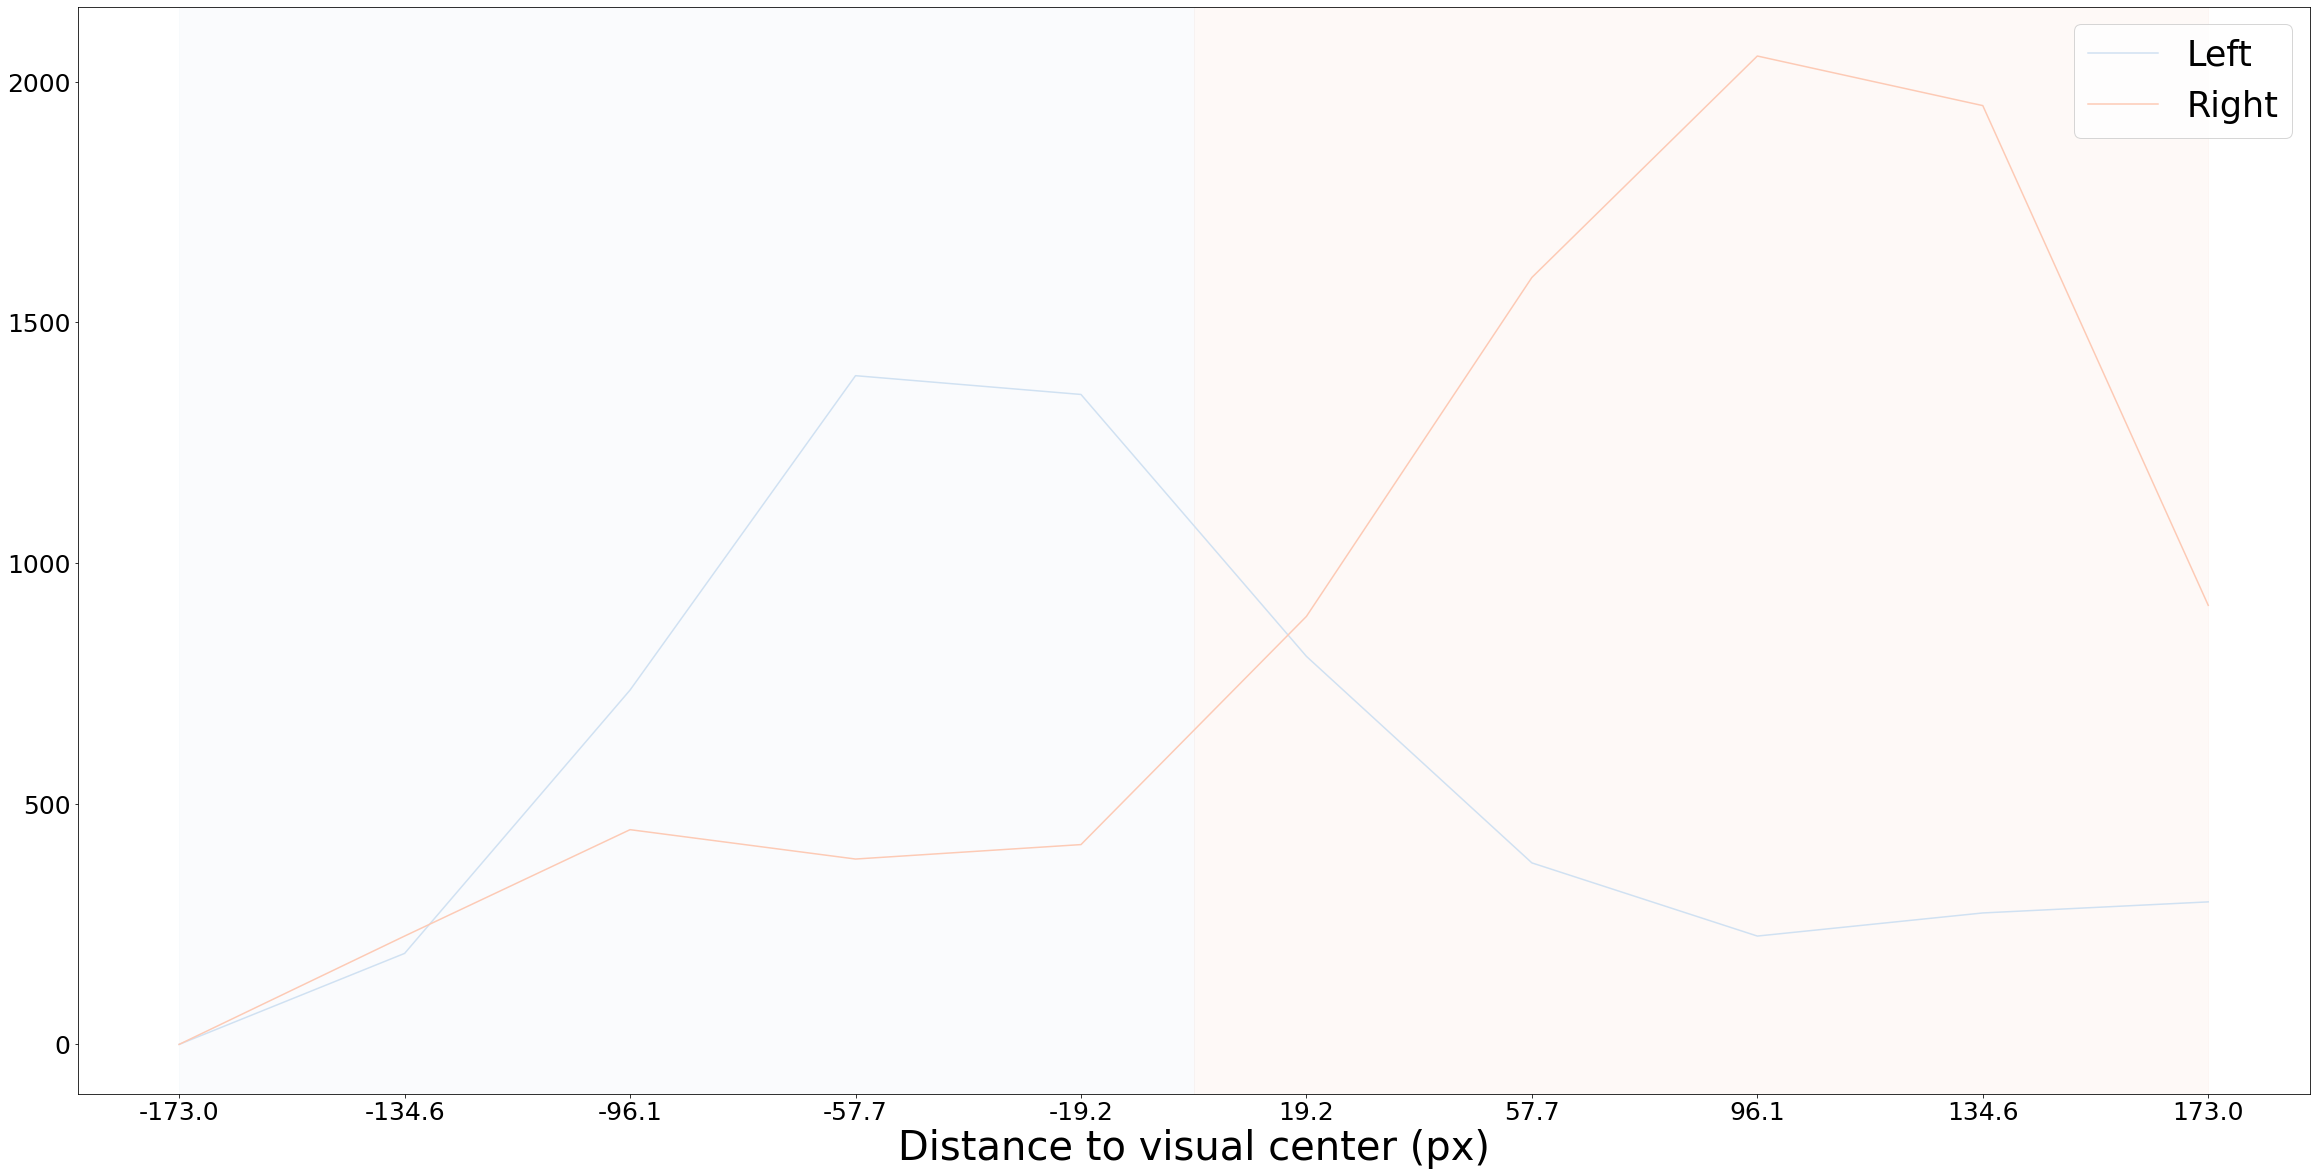

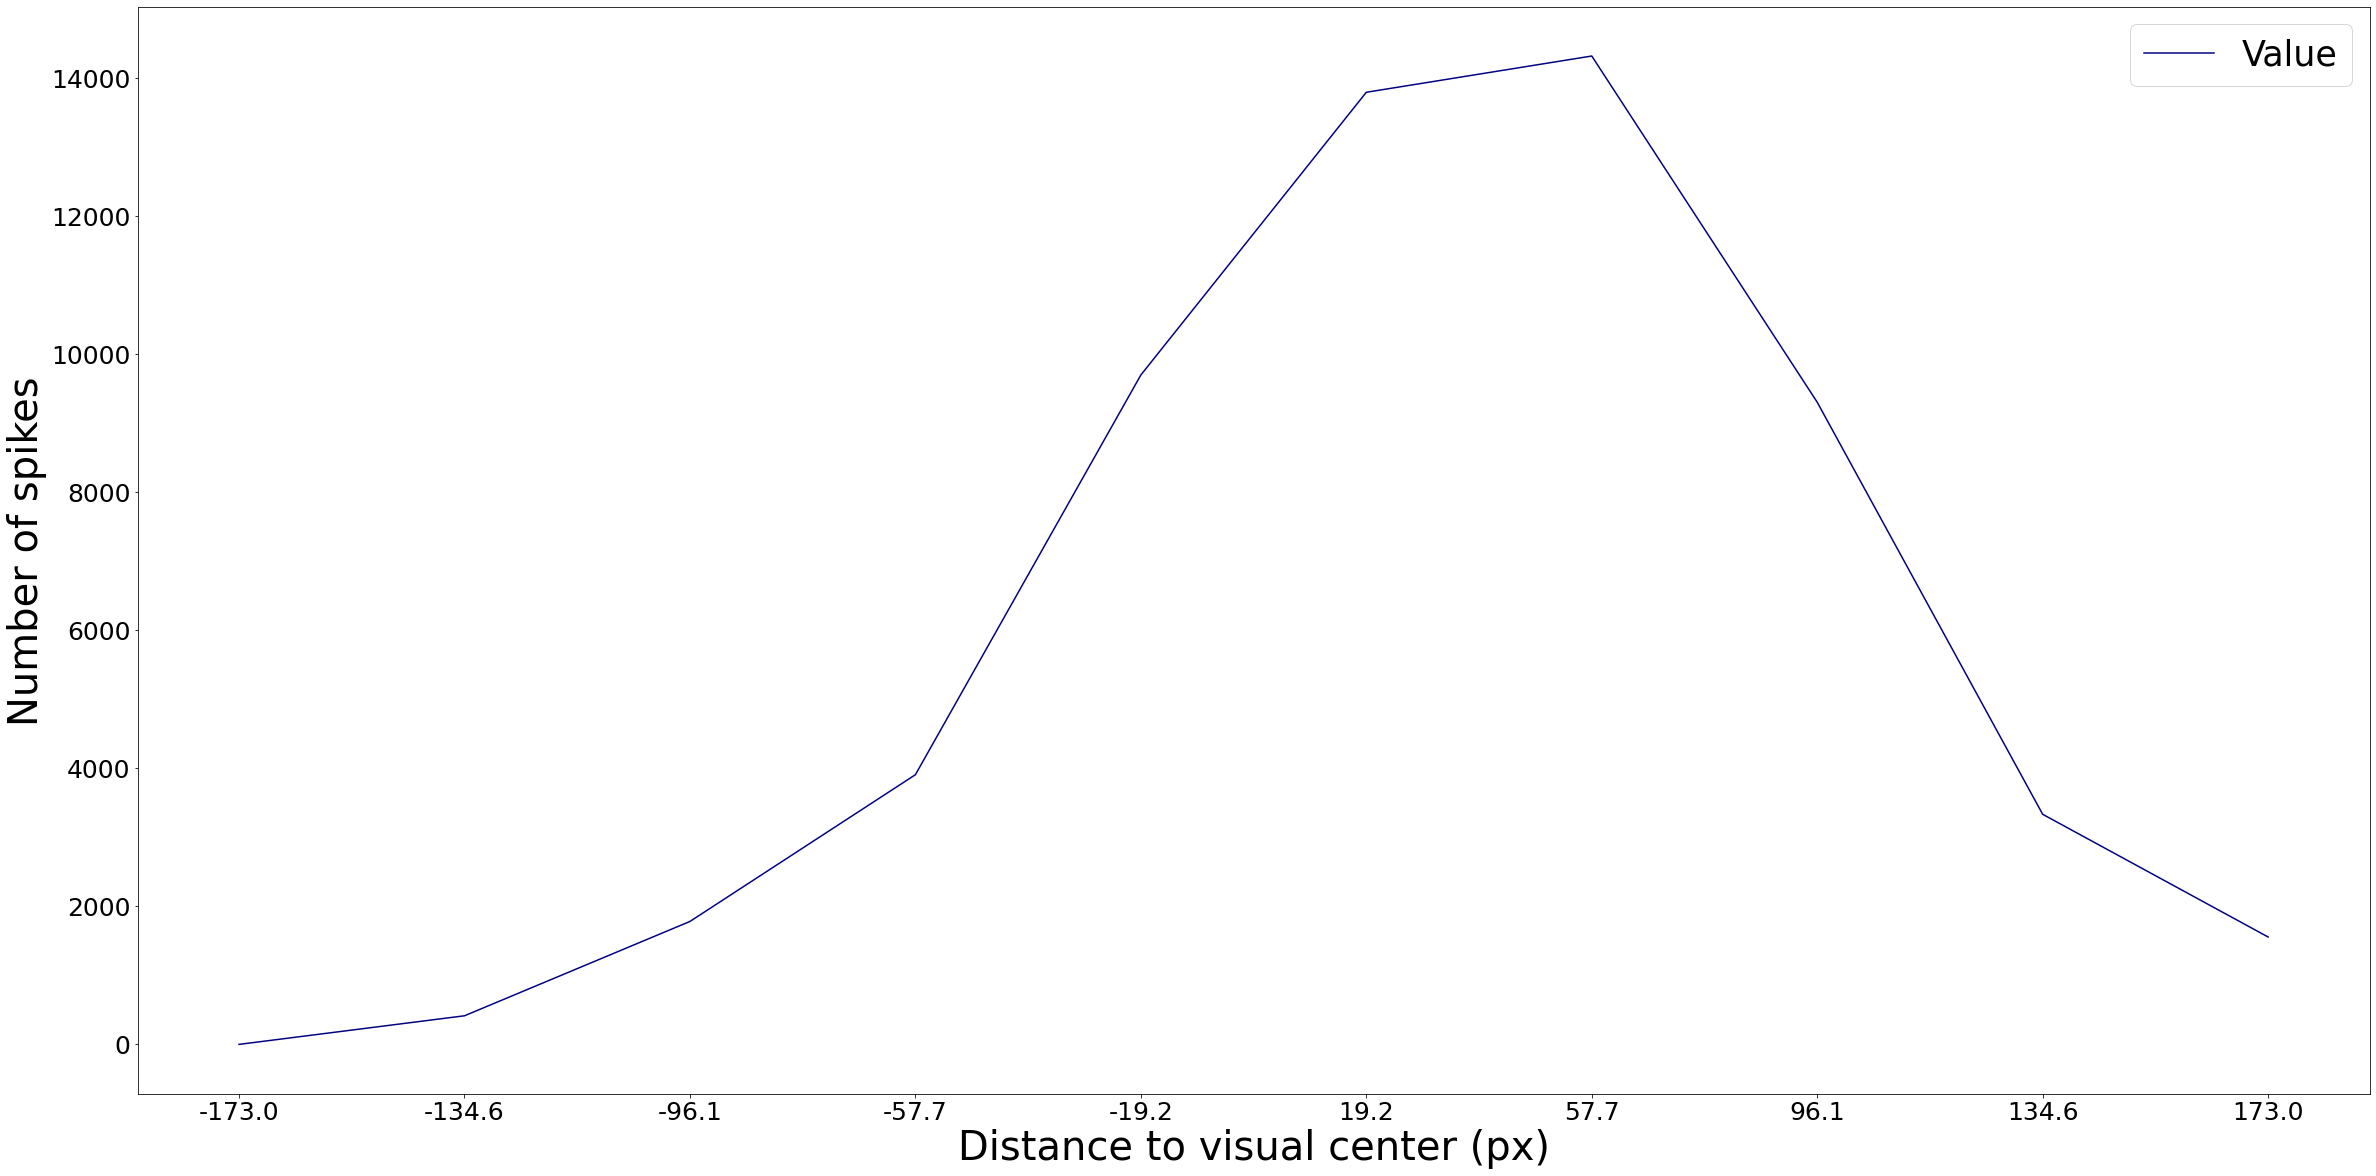

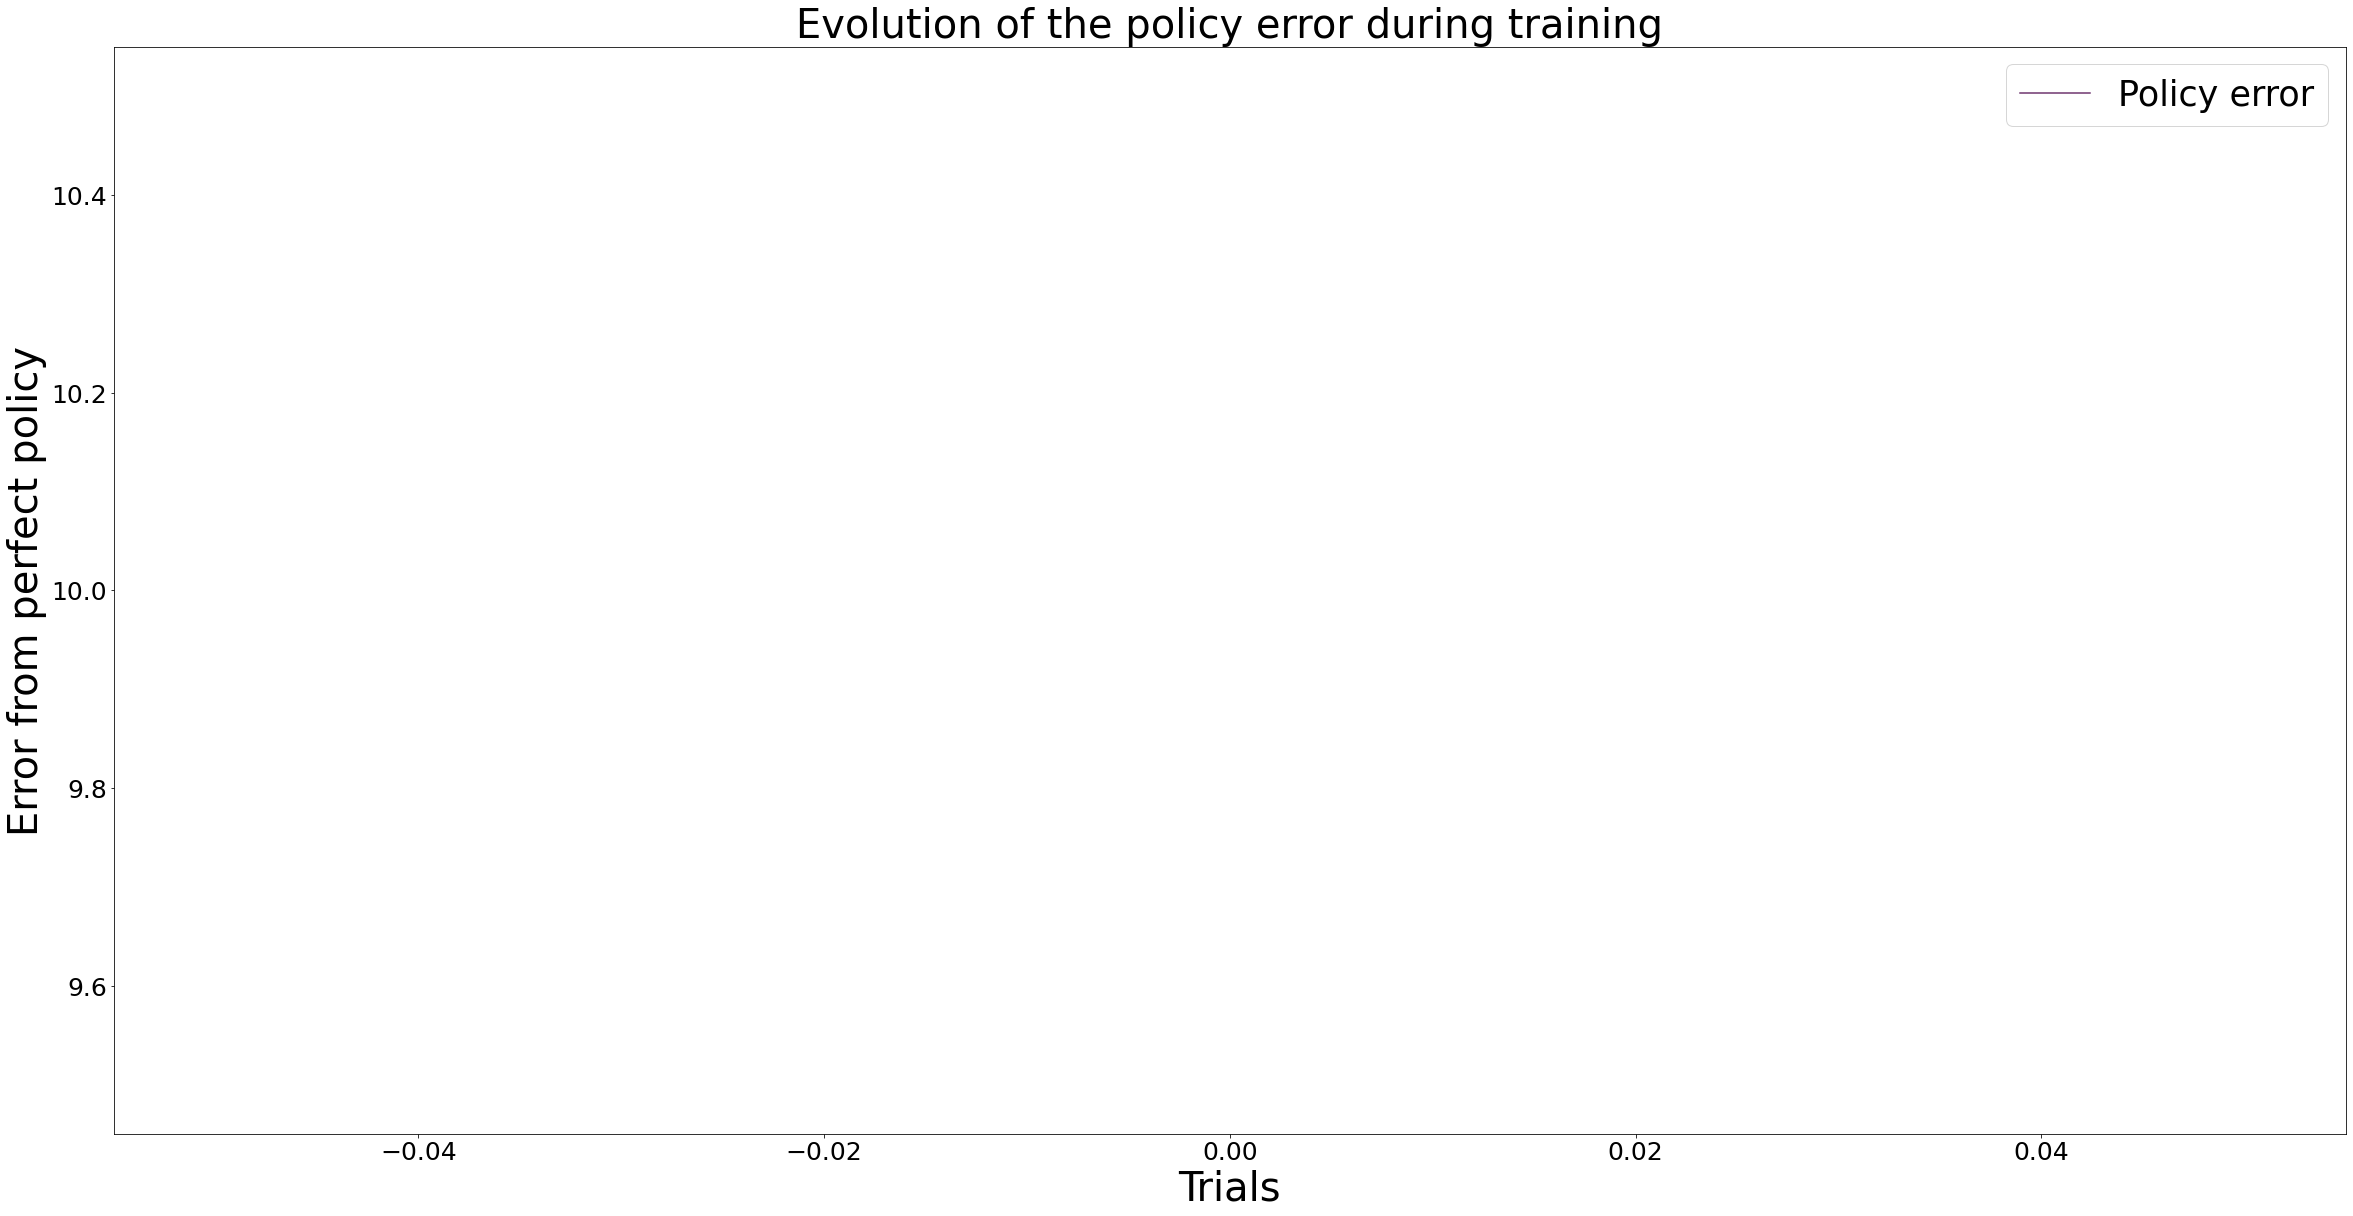

In [161]:
# validation_plot(values, policies, scores, ["Clockwise", "Counter-clockwise"])
validation_plot(values, policies, scores, ["Left", "Right"], "tracking")

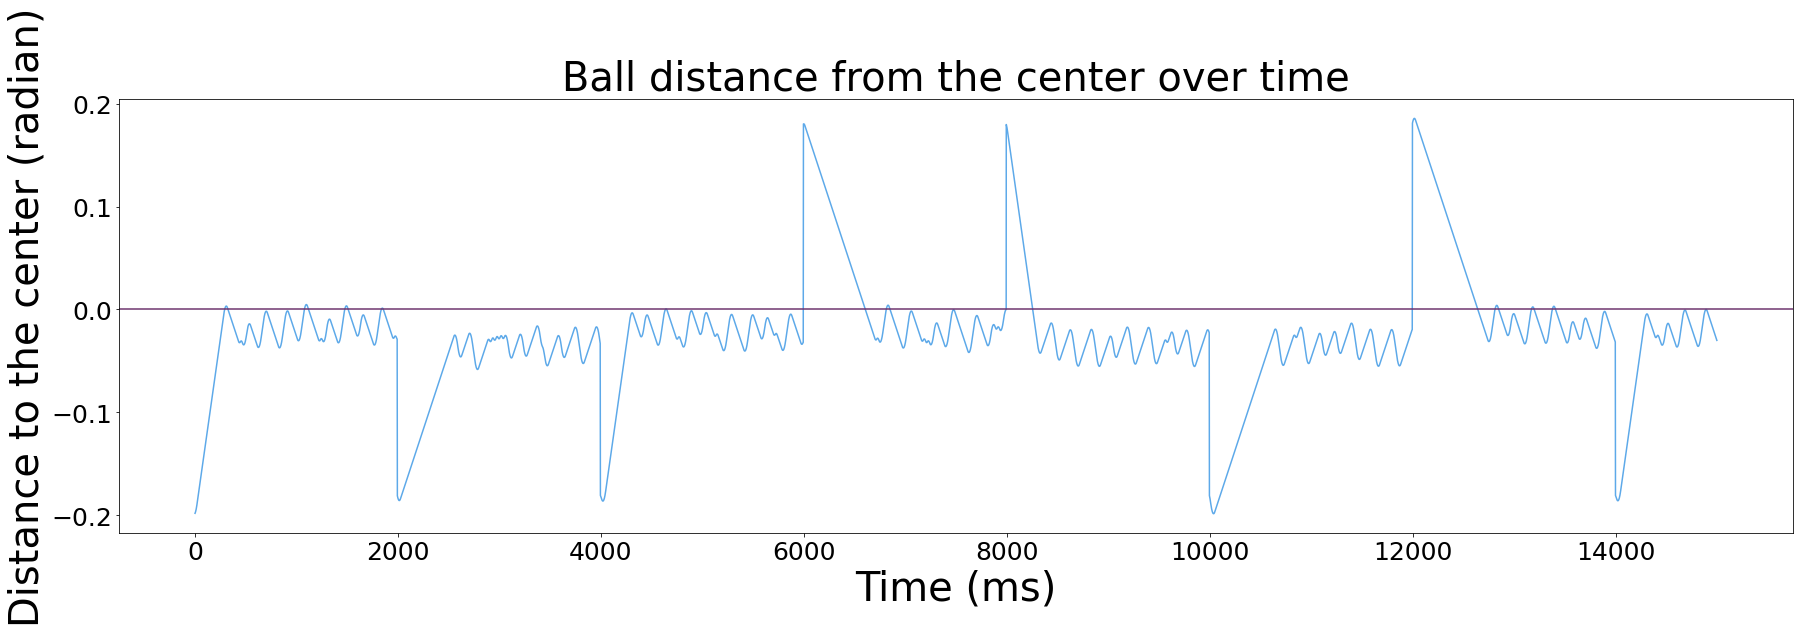

In [172]:
distance = np.load("/home/thomas/distance_inhibition.npy")
plt.figure()
plt.title("Ball distance from the center over time")
plt.xlabel("Time (ms)")
plt.ylabel("Distance to the center (radian)")
plt.plot(distance[0:15000], color="#5DA9E9")
plt.axhline(0, color="#6D326D")

## Critic and Actor neurons weights

In [ ]:
w0 = np.load("/home/thomas/Networks/simulation/rl/tracking_task/tracking_2D/value_policy/weights/2/0_0.npy")
shape = w0.shape
w0 = w0.flatten()

mat = np.zeros((shape[1], shape[0]))
sum = 0
for i in range(shape[0]):
    for j in range(shape[1]):
        for k in range(shape[2]):
            sum += w0[k + j * shape[2] + i * shape[2] * shape[1]]
        mat[j, i] = sum
        sum = 0

plt.imshow(mat)

In [ ]:
nb_layers = len(spinet.neurons)
w = np.zeros((spinet.neurons[nb_layers-2][0].weights.shape[0], spinet.neurons[nb_layers-2][0].weights.shape[1]))
for neuron in spinet.neurons[nb_layers-2]:
    w += np.sum(neuron.weights, axis=2)
plt.figure(figsize=(18, 8))
plt.title("Critic neurons summed weights")
plt.imshow(w.T)
plt.colorbar(orientation="horizontal")
plt.show()

nb_actions = len(spinet.rl_conf["actionMapping"])
nb_neurons_per_action = spinet.l_shape[-1][0] // nb_actions
w = np.zeros((nb_actions, spinet.neurons[nb_layers-1][0].weights.shape[0], spinet.neurons[nb_layers-1][0].weights.shape[1]))
for i in range(nb_actions):
    for j in range(nb_neurons_per_action):
        w[i] += np.sum(spinet.neurons[nb_layers-1][i*nb_neurons_per_action+j].weights, axis=2)

    plt.figure(figsize=(18, 8))
    plt.title("Actor neurons summed weights")
    plt.imshow(w[i].T)
    plt.colorbar(orientation="horizontal")
    plt.show()

## Event rates

In [ ]:
nb_events = np.array(spinet.state["learning_data"]["nbEvents"])[:-1]
t = np.linspace(0, np.max(spinet.spikes[0]), nb_events.size) * 1e-6
plt.figure(figsize=(40, 8))
plt.title("Number of events (every 10ms)")
plt.xlabel("time (s)")
plt.plot(t, nb_events)
plt.show()

## Network configuration parameters

In [ ]:
print("Network config:\n")
pprint.pprint(spinet.conf)
for layer in range(len(spinet.neurons)):
    print("\nLayer " + str(layer) + ":\n")
    pprint.pprint(spinet.neurons[layer][0].conf)

## Load various neuron informations

In [ ]:
simpa_decay, compa_decay = load_array_param(spinet, "learning_decay")
simpa_spike, compa_spike = load_array_param(spinet, "count_spike")

# Plot correlations

df = pd.read_csv(home + "Desktop/test/df")
temp = df.drop(columns=["TRACKING", "SYNAPSE_DELAY", "STDP_LEARNING", "MIN_THRESH"])

correlation_matrix(temp.iloc[:, 25:])
scatter_mat(temp.iloc[:, 25:])

#### Create plots for preferred orientations and directions

In [ ]:
oris, oris_r = hists_preferred_orientations(spinet)
plot_preferred_orientations(spinet, oris, oris_r)